In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the data transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("MNIST data loaded successfully.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(device)


MNIST data loaded successfully.
Number of training samples: 60000
Number of test samples: 10000
cpu


In [56]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 28 * 28),
            nn.Sigmoid()    
        )

    def forward(self, z):
        return self.decoder(z)

class VAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(hidden_dim, latent_dim)
        self.decoder = Decoder(hidden_dim, latent_dim)

    def sample_z(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        z = self.encoder(x)
        mean, log_var = z.chunk(2, dim=1)
        z = self.sample_z(mean, log_var)
        x_reconstructed = self.decoder(z)
        x_reconstructed = x_reconstructed.view(-1, 1, 28, 28)
        return x_reconstructed, mean, log_var
    


In [57]:
v = VAE(hidden_dim=256, latent_dim=32).to(device)
# Count the parameters
total_params = sum(p.numel() for p in v.parameters())
trainable_params = sum(p.numel() for p in v.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 558928
Trainable parameters: 558928


In [58]:
def loss_function(x_reconstructed, x, mean, log_var):
    BCE = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return BCE + KLD

v = VAE(hidden_dim=256, latent_dim=32).to(device)
optimizer = optim.Adam(v.parameters(), lr=1e-3)

In [59]:
def train(epoch):
    v.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_reconstructed, mean, log_var = v(data)
        loss = loss_function(x_reconstructed, data, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"====> Epoch {epoch} Average loss: {train_loss / len(train_loader.dataset)}")

def test():
    v.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            x_reconstructed, mean, log_var = v(data)
            x_reconstructed = torch.clamp(x_reconstructed, 0, 1)  # Ensure values are between 0 and 1
            test_loss += loss_function(x_reconstructed, data, mean, log_var).item()
    test_loss /= len(test_loader.dataset)
    print(f"====> Test set loss: {test_loss:.4f}")

for epoch in range(1, 50):
    train(epoch)
    test()  # Added test() call after each epoch


====> Epoch 1 Average loss: 188.2999915201823
====> Test set loss: 150.9577
====> Epoch 2 Average loss: 137.54103987630208
====> Test set loss: 126.4838
====> Epoch 3 Average loss: 123.184259375
====> Test set loss: 119.4769
====> Epoch 4 Average loss: 117.43079288736979
====> Test set loss: 114.5551
====> Epoch 5 Average loss: 113.82113878580729
====> Test set loss: 111.4514
====> Epoch 6 Average loss: 111.37684646809896
====> Test set loss: 109.7999
====> Epoch 7 Average loss: 109.65817451171876
====> Test set loss: 108.3640
====> Epoch 8 Average loss: 108.3569681640625
====> Test set loss: 107.3817
====> Epoch 9 Average loss: 107.37752573242187
====> Test set loss: 106.6350
====> Epoch 10 Average loss: 106.596666796875
====> Test set loss: 105.8866
====> Epoch 11 Average loss: 105.93763649088541
====> Test set loss: 105.2639
====> Epoch 12 Average loss: 105.38324931640625
====> Test set loss: 105.2463
====> Epoch 13 Average loss: 104.89503422851563
====> Test set loss: 104.5834
====

In [2]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, latent_dim * 2)
        )

    def forward(self, x):
        return self.conv_encoder(x)

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.decoder_linear = nn.Linear(latent_dim, 64 * 4 * 4)
        self.conv_decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.decoder_linear(z)
        z = z.view(-1, 64, 4, 4)
        return self.conv_decoder(z)

class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv_encoder = ConvEncoder(latent_dim)
        self.conv_decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        z = self.conv_encoder(x)
        mean, log_var = z.chunk(2, dim=1)
        z = self.reparameterize(mean, log_var)
        x_reconstructed = self.conv_decoder(z)
        return x_reconstructed, mean, log_var


In [3]:
cv = ConvVAE(latent_dim=32).to(device)
# Count the parameters
total_params = sum(p.numel() for p in cv.parameters())
trainable_params = sum(p.numel() for p in cv.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 211041
Trainable parameters: 211041


In [4]:
def loss_function(x_reconstructed, x, mean, log_var):
    BCE = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return BCE + KLD

cv = ConvVAE(latent_dim=32).to(device)
optimizer = optim.Adam(cv.parameters(), lr=1e-3)

In [5]:
def train(epoch):
    cv.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_reconstructed, mean, log_var = cv(data)
        loss = loss_function(x_reconstructed, data, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"====> Epoch {epoch} Average loss: {train_loss / len(train_loader.dataset)}")

def test():
    cv.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            x_reconstructed, mean, log_var = cv(data)
            x_reconstructed = torch.clamp(x_reconstructed, 0, 1)  # Ensure values are between 0 and 1
            test_loss += loss_function(x_reconstructed, data, mean, log_var).item()
    test_loss /= len(test_loader.dataset)
    print(f"====> Test set loss: {test_loss:.4f}")

for epoch in range(1, 50):
    train(epoch)
    test()  # Added test() call after each epoch


====> Epoch 1 Average loss: 169.73536875
====> Test set loss: 118.7123
====> Epoch 2 Average loss: 113.51606318359374
====> Test set loss: 109.2178
====> Epoch 3 Average loss: 108.18388380533854
====> Test set loss: 105.8626
====> Epoch 4 Average loss: 106.10699200846354
====> Test set loss: 104.4580
====> Epoch 5 Average loss: 104.8271139811198
====> Test set loss: 103.7765
====> Epoch 6 Average loss: 103.9559329264323
====> Test set loss: 102.9773
====> Epoch 7 Average loss: 103.28059630533855
====> Test set loss: 102.2406
====> Epoch 8 Average loss: 102.67418059895833
====> Test set loss: 101.6645
====> Epoch 9 Average loss: 102.24797571614583
====> Test set loss: 101.7180
====> Epoch 10 Average loss: 101.85603092447917
====> Test set loss: 101.0529
====> Epoch 11 Average loss: 101.49247330729166
====> Test set loss: 101.1469
====> Epoch 12 Average loss: 101.20227750651041
====> Test set loss: 100.5631
====> Epoch 13 Average loss: 100.89254306640625
====> Test set loss: 100.9389
===

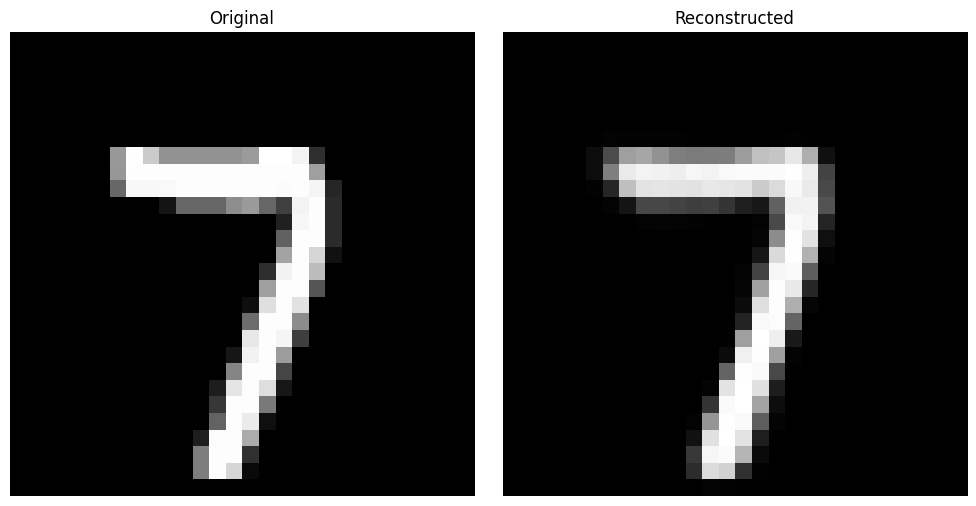

In [8]:
# Generate and display a reconstructed image
cv.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Get a random batch of test data
    random_idx = torch.randint(0, len(test_loader.dataset), (1,)).item()
    test_data = test_loader.dataset[random_idx][0].unsqueeze(0).to(device)
    
    # Generate a reconstruction
    x_reconstructed, _, _ = cv(test_data)
    
    # Ensure the values are between 0 and 1
    x_reconstructed = torch.clamp(x_reconstructed, 0, 1)
    
    # Convert to numpy arrays for plotting
    original = test_data[0].cpu().numpy().reshape(28, 28)
    reconstructed = x_reconstructed[0].cpu().numpy().reshape(28, 28)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the original image
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    
    # Plot the reconstructed image
    ax2.imshow(reconstructed, cmap='gray')
    ax2.set_title('Reconstructed')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


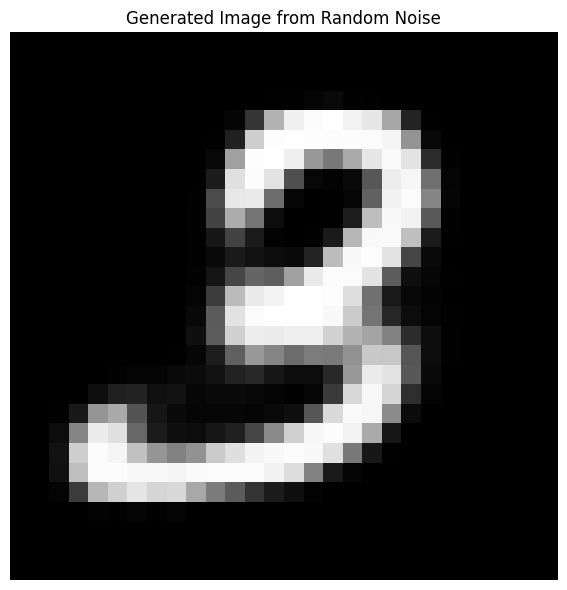

In [17]:
# Generate an image from a random noise vector
cv.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Generate a random noise vector
    z = torch.randn(1, 32).to(device)
    
    # Generate an image from the noise vector
    generated_image = cv.conv_decoder(z)
    
    # Ensure the values are between 0 and 1
    generated_image = torch.clamp(generated_image, 0, 1)
    
    # Convert to numpy array for plotting
    generated_image = generated_image[0].cpu().numpy().reshape(28, 28)

    # Create a figure
    plt.figure(figsize=(6, 6))
    
    # Plot the generated image
    plt.imshow(generated_image, cmap='gray')
    plt.title('Generated Image from Random Noise')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
class Z2CNNLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3, use_maxpool=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, 20, kernel_size=kernel_size, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) if use_maxpool else nn.Identity(),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        return self.layer(x)


class Z2CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(
            Z2CNNLayer(1, use_maxpool=False),
            Z2CNNLayer(20),
            Z2CNNLayer(20),
            Z2CNNLayer(20),
            Z2CNNLayer(20),
            Z2CNNLayer(20),
            Z2CNNLayer(20, kernel_size=4),
        )

    def forward(self, x):
        return self.net(x)